# MEWpy Simulation 

This notebook exemplifies how MEWpy may be used as an interface for COBRApy and REFRAMED.

Models can be loaded using REFRAMED: 

In [11]:
from reframed.io.sbml import load_cbmodel
model = load_cbmodel('models/ec/iML1515.xml',flavor='cobra')

or using COBRApy:

In [13]:
from cobra.io import read_sbml_model
model = read_sbml_model('models/ec/iML1515.xml')

A simulator object provides a common interface to realize the main phenotype analysis tasks. The *get_simulator* function returns a simulator, a wrapper,  for the provided model. The simulator interface remains the same regardless of how the model was loaded, using REFRAMED or COBRApy. This simplify the use of both environments and ease the management of future changes and deprecation on their APIs.


In [14]:
from mewpy.simulation import get_simulator
simul = get_simulator(model)

The simulator offers a wide API, and enable to perform basic tasks, such as, list  metabolites, reactions, genes and compartments:

In [15]:
simul.metabolites[:10]

['octapb_c',
 'cysi__L_e',
 'dhap_c',
 'prbatp_c',
 '10fthf_c',
 'btal_c',
 '6pgg_c',
 'co2_e',
 'akg_e',
 'gsn_e']

In [16]:
simul.reactions[:10]

['CYTDK2',
 'XPPT',
 'HXPRT',
 'NDPK5',
 'SHK3Dr',
 'NDPK6',
 'NDPK8',
 'DHORTS',
 'OMPDC',
 'PYNP2r']

In [17]:
simul.genes[:10]

['b2551',
 'b0870',
 'b3368',
 'b2436',
 'b0008',
 'b3500',
 'b2465',
 'b0945',
 'b4467',
 'b3126']

In [18]:
simul.compartments

{'c': 'cytosol', 'e': 'extracellular space', 'p': 'periplasm'}

A simulator may also be loaded considering environmental conditions, that will be considered during phenotype simulations. In the next example, glucose consumption is limited to 10 mmol/gDW/h and the oxygen is unlimited.

In [20]:
envcond = {'EX_glc__D_e': (-10.0, 100000.0),
           'EX_o2_e':(-1000,1000)}

simul = get_simulator(model,envcond=envcond)

All phenotype simulations will consider the imposed environmental conditions, and as such they only need to be set once. Also, these conditions do not persistently alter the model, which can be reused with a different simulator instance.

## Phenotype simulation

Phenotype simulations are also run using the simulator instance using  the `simulate` method. 

In [21]:
# FBA 
result = simul.simulate()
# or 
result = simul.simulate(method='FBA')

result

objective: 0.8769972144269748
Status: OPTIMAL

Flux Balance Analysis (FBA) can be run without identifying any method, or  by passing the 'FBA' as method parameter. Other phenotype simulation methods may also be run using one of the identifiers:

- Flux Balance Analysis: `method = 'FBA'`
- Parsimonious FBA:`method = 'pFBA'`
- Minimization of Metabolic Adjustment:`method = 'MOMA'`
- Linear MOMA: `method = 'lMOMA'`
- Regulatory on/off minimization of metabolic flux: `method = 'ROOM'`

In [22]:
# pFBA
result = simul.simulate(method = 'pFBA')

result

objective: 769.7902399146501
Status: OPTIMAL

## Reaction fluxes

The phenotype simulation result object, besides containing the objective value and solver status, also include reaction fluxes in the form of a dictionary:


In [23]:
result.fluxes

OrderedDict([('CYTDK2', 0.0),
             ('XPPT', 0.0),
             ('HXPRT', 0.0),
             ('NDPK5', 0.0),
             ('SHK3Dr', 0.33424030136519417),
             ('NDPK6', 0.0),
             ('NDPK8', 0.0),
             ('DHORTS', -0.290106293546371),
             ('OMPDC', 0.290106293546371),
             ('PYNP2r', 0.0),
             ('G5SD', 0.19386461923515486),
             ('CS', 6.913003110880989),
             ('ICDHyr', 6.913003110880989),
             ('ALATA_L2', 0.0),
             ('DURIPP', 0.0),
             ('ACALD', 0.0),
             ('PTRCTA', 0.0),
             ('ACS', 0.0),
             ('CYSDS', 0.0),
             ('MAN6PI', 0.0),
             ('PPA', 3.070860997140544),
             ('APRAUR', 0.0003911407576345045),
             ('TRPAS2', -0.049851152659672514),
             ('PPCK', 0.0),
             ('ME1', 0.0),
             ('DB4PS', 0.000782281515269009),
             ('ALAR', 0.036554997891745156),
             ('RBFK', 0.0001955703788172892)

In [24]:
result.data_frame

Reaction ID     Flux
0         CYTDK2  0.00000
1           XPPT  0.00000
2          HXPRT  0.00000
3          NDPK5  0.00000
4         SHK3Dr  0.33424
...          ...      ...
2707        MPTS  0.00000
2708       MOCOS  0.00000
2709     BMOGDS2  0.00000
2710      FESD2s  0.00000
2711      OCTNLL  0.00000

[2712 rows x 2 columns]

Individual reaction flux values can be obtained from the dictionary representation. For example, the *Prephenate dehydratase* reaction flux can be obtained from the previous pFBA simulation using the reaction identifier:

In [25]:
result.fluxes['PPNDH']

0.16247688893081344

## Retrieving and setting the model objective

The simulation objective, when running FBA or pFBA phenotype simulations, is, by default, the model objective which can be seen using the simulator.

In [26]:
simul.objective

{'BIOMASS_Ec_iML1515_core_75p37M': 1.0}

The simulator may also be used to change the model objective, for example, to optimize the ATP maintenance requirement (ATPM):

In [27]:
simul.objective = 'ATPM'

In [28]:
simul.objective

{'ATPM': 1.0}

In [29]:
simul.objective='BIOMASS_Ec_iML1515_core_75p37M'

## Adding additional constraints to phenotype simulations

Simulations may include additional metabolic constraints on reaction fluxes. From the previous pFBA simulation one can observe that the organism does not produce L-tyrosine:

In [30]:
result.fluxes['EX_tyr__L_e']

0.0

Additional constraints may be added to the model so that the organism start to produce this aromatic amino acid. We may alter, for example, the *3-dehydroquinate dehydratase* reaction bounds, among others, starting by verifying its initial bounds:

In [31]:
simul.get_reaction_bounds('DHQTi')

(0.0, 1000.0)

In [32]:
constraints = {'DHQTi': (1, 10000),
               'PPC': (16.791619483918264, 10000),
               'FADRx2': (0, 0.0),
               'PDH': (0, 0)}

# run a pFBA simulation accounting with the new constraint
result = simul.simulate(method='pFBA',constraints=constraints)

result.fluxes['EX_tyr__L_e']

0.7362937237983241

Note that the modifications are not persistently applied to the model, they only exist during the simulation.

We also need to verify that the organism continues to grow:

In [34]:
result.fluxes['BIOMASS_Ec_iML1515_core_75p37M']

0.691926343744802

We can also plot the production envelope:

<AxesSubplot:xlabel='BIOMASS_Ec_iML1515_core_75p37M', ylabel='EX_tyr__L_e'>

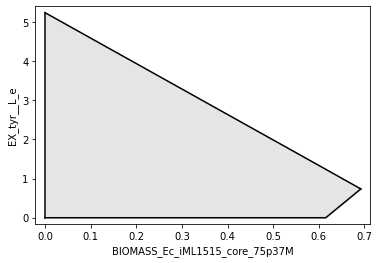

In [37]:
%matplotlib inline
from mewpy.visualization.envelope import plot_flux_envelope

plot_flux_envelope(simul,'BIOMASS_Ec_iML1515_core_75p37M','EX_tyr__L_e',constraints = constraints)

The `simulate` method includes additional parameters, such as the optimization direction. For a full description please refer to the module documentation. 

## Flux Variability Analysis

The simulator interface also allows to perform Flux Variability Analysis (FVA) for L-tyrosine:


In [39]:
# returns a dictionar
simul.FVA(reactions=['EX_tyr__L_e'])

{'EX_tyr__L_e': [0.0, 0.5721226993865252]}

In [41]:
# or a data frame
simul.FVA(reactions=['EX_tyr__L_e'],format='df')

Reaction ID  Minimum   Maximum
0  EX_tyr__L_e      0.0  0.572123

By default, MEWpy sets the model objective fraction to 90%, however this fraction may be altered. For example, one might want to consider a fraction of 10% from optimal growth:

In [42]:
simul.FVA(reactions=['EX_tyr__L_e'],obj_frac=0.1)

{'EX_tyr__L_e': [0.0, 5.086103322262054]}

The FVA simulations are run considering the defined environmental conditions. Additional constraints may be added, or changed, such as the previouly used to increase L-tyrosine production.

In [43]:
simul.FVA(reactions=['EX_tyr__L_e'], constraints=constraints)

{'EX_tyr__L_e': [0.0, 1.1883110320942545]}

COBRApy users may have noticed that this same task would have required many additional coding lines if using the COBRApy API directly.

## Genes and reactions essentiality

Gene and reaction essentiality tests identify, respectively, the list of genes and reactions whose deletion would prevent the organism to grow. 

In [44]:
simul.essential_reactions

['SHK3Dr',
 'DHORTS',
 'OMPDC',
 'G5SD',
 'CS',
 'ICDHyr',
 'PPA',
 'APRAUR',
 'DB4PS',
 'ALAR',
 'RBFK',
 'ASPTA',
 'RBFSb',
 'EX_pi_e',
 'SHCHD2',
 'A5PISO',
 'PMDPHT',
 'ILETA',
 'IPPMIb',
 'ORPT',
 'RBFSa',
 'ACHBS',
 'DHAD2',
 'ACLS',
 'PSCVT',
 'ANS',
 'ANPRT',
 'CHORM',
 'CHORS',
 'IGPS',
 'LEUTAi',
 'DMATT',
 'GRTT',
 'UPP3S',
 'UPPDC1',
 'EX_mn2_e',
 'MOAT',
 'UDCPDPS',
 'USHD',
 'HCO3E',
 'IMPC',
 'LPADSS',
 'GLUTRS',
 'TDSK',
 'TMPPP',
 'DHQTi',
 'IPMD',
 'AIRC3',
 'ADSL2r',
 'TMDS',
 'PPCDC',
 'DHAD1',
 'IPPMIa',
 'FMNAT',
 'KARA1',
 'KARA2',
 'ACCOAC',
 'NADK',
 'GLUTRR',
 'ARGSS',
 'AGPR',
 'G1SAT',
 'KDOCT2',
 'DXPS',
 'CDPMEK',
 'MECDPS',
 'PGAMT',
 'UAGDP',
 'UAGCVT',
 'GLUR',
 'NNDPR',
 'EX_zn2_e',
 'DNMPPA',
 'HPPK2',
 'PTPATi',
 'DXPRIi',
 'GTPCII2',
 'SADT2',
 'OPHBDC',
 'SDPDS',
 'ADCS',
 'ADCL',
 'UMPK',
 'UAPGR',
 'CTPS2',
 'PAPPT3',
 'UAGPT3',
 'ACODA',
 'FCLT',
 'HBZOPT',
 'PNTK',
 'ADSS',
 'OCTDPS',
 'DPCOAK',
 'ASPCT',
 'KDOPS',
 'KDOPP',
 'MCOATA',
 'DAPE',

In [45]:
simul.essential_genes

['b3368',
 'b1260',
 'b0109',
 'b1094',
 'b2472',
 'b1261',
 'b3770',
 'b0243',
 'b0414',
 'b3041',
 'b0025',
 'b1662',
 'b0421',
 'b3804',
 'b3997',
 'b3187',
 'b4006',
 'b2400',
 'b3993',
 'b1062',
 'b1281',
 'b0639',
 'b0720',
 'b1136',
 'b2103',
 'b3642',
 'b0415',
 'b3648',
 'b3771',
 'b3972',
 'b0071',
 'b0072',
 'b0908',
 'b1263',
 'b1264',
 'b2599',
 'b2600',
 'b2329',
 'b3633',
 'b1262',
 'b0174',
 'b0524',
 'b0182',
 'b0915',
 's0001',
 'b2026',
 'b0523',
 'b1131',
 'b2024',
 'b3607',
 'b4214',
 'b2762',
 'b2827',
 'b3433',
 'b3639',
 'b2838',
 'b4040',
 'b3974',
 'b0103',
 'b1693',
 'b2942',
 'b1215',
 'b3198',
 'b0417',
 'b1098',
 'b1210',
 'b0522',
 'b2687',
 'b3960',
 'b3172',
 'b0242',
 'b0074',
 'b3958',
 'b1091',
 'b0154',
 'b0918',
 'b0159',
 'b3176',
 'b3730',
 'b3189',
 'b3967',
 'b2763',
 'b0386',
 'b2764',
 'b2323',
 'b2507',
 'b0142',
 'b3634',
 'b0778',
 'b0173',
 'b1812',
 'b3360',
 'b3843',
 'b2478',
 'b3729',
 'b2312',
 'b1740',
 'b2780',
 'b0087',
 'b0090',


For more options and methods please refer to the MEWpy documentation